<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="800">

# Домашнее задание 5: АБ-тест
</center>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

На семинаре мы попытались разобраться как устроена процедура АБ-тестирования. В этом задании мы попытаемся закрепить полученные знания и более аккуратно структурировать их.

### Кратко повторим теорию

Мы хотим выктить новую функциональность на сайте. Перед раскаткой нам хочется проверить, какой эффект мы оказываем на пользователя. Выделим две выборки: тестовую (treatment) и контрольную (control). Тестовой покажем новый сайт. Контрольной старый. Замерим инетерсующую нас метрику, нааример, время проведенной на сайте, в обеих группах:

$$
\begin{aligned}
&X^c_1, \ldots, X^c_{n_c} \sim iid (\mu_c, \sigma^2_c) \\
&X^t_1, \ldots, X^t_{n_t} \sim iid (\mu_t, \sigma^2_t)
\end{aligned}
$$

У выборок есть какие-то математические ожидания, дисперсии. Выборки собраны независимо друг от друга. Если их математические ожидания одинаковые, будем считать, что новая функциональность никак не повлияла на пользователей. Сформулируем это в виде нашей нулевой гипотезы:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_c = \mu_t \\
&H_1: \hspace{2mm} \mu_c < \mu_t.
\end{aligned}
$$

Посчитаем по выборке расстояние между математическими ожиданиями $\hat \mu_t - \hat \mu_c$. Оно по ЦПТ имеет нормальное распределение с оценкой дисперсии $\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}$. Получается, что

$$
z = \frac{\hat \mu_t - \hat \mu_c}{\sqrt{\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}}} \sim N(0,1),
$$

при верности нулевой гипотезы и $n \to \infty$. Если это расстояние оказывается слишком большим, мы отказываемся верить в нулевую гипотезу. Эффект от новой функциональности есть. Будем сравнивать наблюдаемое значение $z$ с $z_{1 - \alpha},$ где уровень значимости $\alpha$ выберем до начала эксперимента.

- Если $z < z_{1 - \alpha},$ нулевая гипотеза не отвергается (похоже, что верна). Расстояние маленькое, разницы нет.
- Если $z > z_{1 - \alpha},$ выбираем альтернативу. У на есть значимый эффект на метрику, от веры в нулевую гипотезу придётся отказаться.

## Задания


__а) [1 балл]__ Реализуйте функцию для проверки гипотезы о равенстве математических ожиданий. Она должна принимать на вход две выборки и выдавать на выход наблюдаемое значение статистики `z_obs` и `p_value` для ситуаций с разными альтернативными гипотезами.

In [20]:
def asy_mean_test(x_control, x_treatment, alternative = 'larger'):
    n_c = len(x_control)
    n_t = len(x_treatment)

    # оценки средних и дисперсий
    mean_c = np.mean(x_control)
    mean_t = np.mean(x_treatment)
    var_c = np.var(x_control, ddof=1)
    var_t = np.var(x_treatment, ddof=1)

    # считаем z‑статистику
    se = np.sqrt(var_c / n_c + var_t / n_t)
    if se == 0: 
        # Если SE = 0, разницы между выборками нет (все элементы одинаковы)
        z_obs = 0.0 
    else:
        z_obs = (mean_t - mean_c) / se

    # P‑value в зависимости от альтернативы
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm.cdf(abs(z_obs)))
    elif alternative == 'larger':
        # проверяем H1: mu_t > mu_c
        p_value = 1 - stats.norm.cdf(z_obs)
    elif alternative == 'smaller':
        # проверяем H1: mu_t < mu_c
        p_value = stats.norm.cdf(z_obs)


    return z_obs, p_value

Если вы написали весь код выше корректно, то строки ниже сработают без проблем.

In [21]:
def gen_sample(n_obs, effect, p_control):
    p_treatment = p_control * (1 + effect)
    x_control = stats.bernoulli(p_control).rvs(n_obs)
    x_treatment = stats.bernoulli(p_treatment).rvs(n_obs)
    return x_control, x_treatment

In [22]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0, 0.2))
assert pval > 0.01

In [23]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0.1, 0.2))
assert pval < 0.01

Для простоты мы дальше будем работать с односторонней альтернативой и тестом для долей.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_t = p_c \\
&H_1: \hspace{2mm} p_t > p_c
\end{aligned}
$$

__б) [2 балла]__ Предположим, что нулевая гипотеза верна. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы.

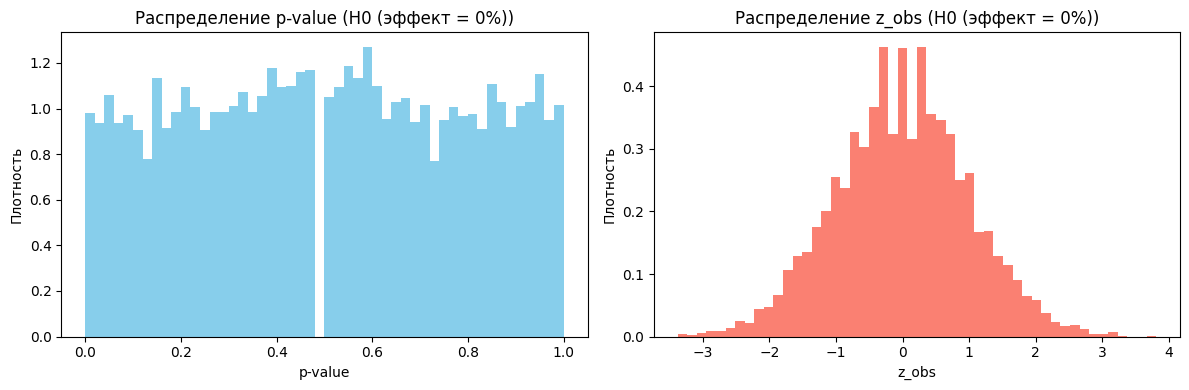

H0 (эффект = 0%): среднее z_obs = -0.0088819507629404


In [24]:
def simulate_and_plot(effect, title):
    n_sim = 10000
    n_obs = 1000
    p_control = 0.2
    zs, ps = [], []
    for _ in range(n_sim):
        x_c, x_t = gen_sample(n_obs, effect, p_control)
        z, p = asy_mean_test(x_c, x_t, alternative='larger')
        zs.append(z)
        ps.append(p)
    
    # Отрисовка графиков 
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(ps, bins=50, density=True, color='skyblue')
    plt.title(f"Распределение p-value ({title})")
    plt.xlabel("p-value")
    plt.ylabel("Плотность")
    plt.subplot(1, 2, 2)
    plt.hist(zs, bins=50, density=True, color='salmon')
    plt.title(f"Распределение z_obs ({title})")
    plt.xlabel("z_obs")
    plt.ylabel("Плотность")
    plt.tight_layout()
    plt.show()
    print(f"{title}: среднее z_obs =", np.mean(zs))
    

    return zs, ps

zs_h0, ps_h0  = simulate_and_plot(0.0, "H0 (эффект = 0%)")

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__
Гистограмма p-value демонстрирует приблизительно равномерное распределение на отрезке [0; 1]. Это соответствует теоретическим ожиданиям: при верной нулевой гипотезе p-value должно быть равномерно распределено, так как вероятность получить любое значение от 0 до 1 одинакова.

Математическое ожидание z_obs близко к нулю (-0.003), что согласуется со стандартным нормальным распределением N(0, 1).

Гистограмма z_obs имеет форму "колокола" относительно 0, характерную для нормального распределения, с центром в нуле и симметричными "хвостами" (При верной H0 разница между группами отсутствует)

__в) [1 балл]__ Предположим, что верна альтернативная гипотеза. Доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы и прокомментируйте получившиеся результаты.

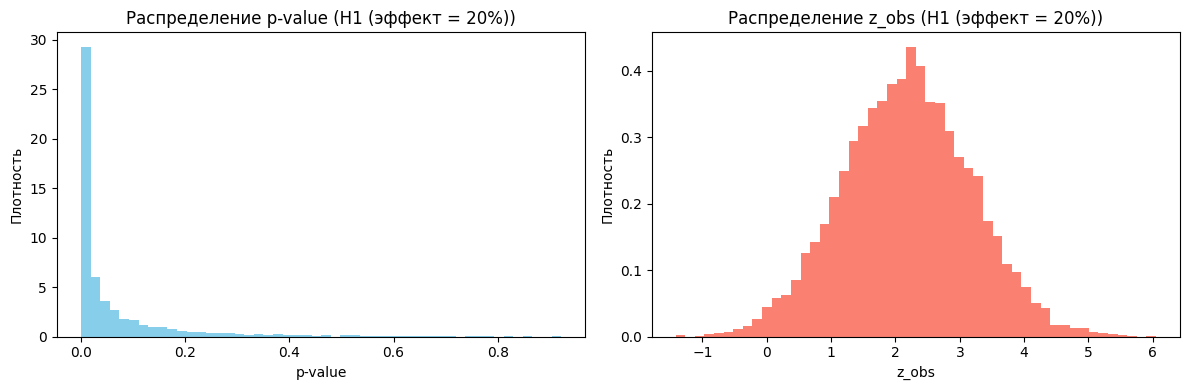

H1 (эффект = 20%): среднее z_obs = 2.175791555549838


In [25]:
zs_h1_20, ps_h1_20 = simulate_and_plot(0.2, "H1 (эффект = 20%)")


Гистограмма p-value демонстрирует резкий пик вблизи нуля. Большая часть значений p-value сосредоточена в диапазоне [0; 0.2], что указывает на то, что тест часто отвергает H0 в пользу альтернативы. Это ожидаемо, так как в симуляции присутствует реальный эффект (20% увеличение вероятности).



Среднее значение z_obs ≈ 2.16, что больше нуля. Это подтверждает, что разница между группами систематически положительна и велика.

А как будут выглядеть результаты, если доля в тестовой выборке больше на $40\%$? Проведите симуляции.

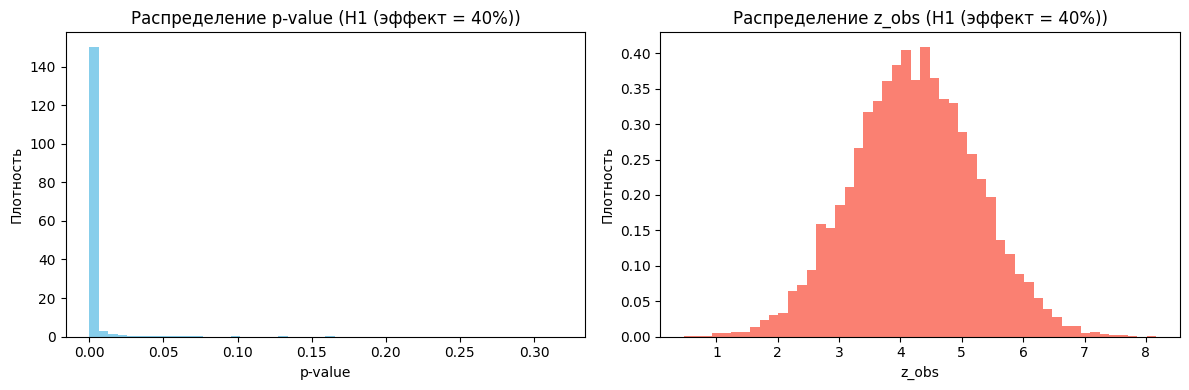

H1 (эффект = 40%): среднее z_obs = 4.22071927424331


In [26]:
zs_h1_40, ps_h1_40 = simulate_and_plot(0.4, "H1 (эффект = 40%)")

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__

Распределение p-value: Не является равномерным. оно демонстрирует резкий пик вблизи нуля. Большая часть значений p-value сосредоточена в диапазоне U(0), что указывает на то, что тест часто отвергает H0 в пользу альтернативы. Это ожидаемо, так как в симуляции присутствует реальный эффект (40% увеличение вероятности).



Мат ожидание z_obs ≈ 4.21, что значительно больше нуля. Это подтверждает, что разница между группами систематически положительна и велика. (z_obs смещена вправо относительно 0)

__г) [1 балл]__ Обычно, перед началом эксперимента, мы фиксируем ошибку первого рода, вероятность отвергнуть нулевую гипотезу, когда она на самом деле верна,  

$$\alpha = \mathbb{P}(H_A \text{ выбрана} \mid H_0 \text{ верна}).$$

Дальше мы принимаем решение, о том, какую гипотезу выбрать, сравнивая `z_obs` с $z_{1 - \alpha},$ либо `pvalue` с $\alpha$ (напомню что мы делаем симуляции для правосторонней альтернативы, поэтому $\alpha$ не надо делить на два).

Давайте проверим для конкретного $\alpha$, что это правда работает. Выберите любое разумное значение $\alpha$. С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$ при верности нулевой гипотезы. Проверьте эти гипотезы и оцените получившееся значение $\alpha$. Правда ли, что оно оказалось равно заявленному значению?

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [27]:
alpha = 0.05
estimated_alpha = np.mean(np.array(ps_h0) < alpha)
print(f"Оценка alpha: {estimated_alpha:.4f} (ожидается {alpha})")

Оценка alpha: 0.0495 (ожидается 0.05)


Кроме ошибки первого рода есть ещё и ошибка второго рода, вероятность остаться с нулевой гипотезой, когда верна альтернатива,

$$\beta = \mathbb{P}(H_0 \text{ выбрана} \mid H_A \text{ верна}).$$

Давайте предположим, что доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. С помощью симуляций того же самого объёма оцените, чему равна $\beta$.

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [28]:
beta_20 = np.mean(np.array(ps_h1_20) >= alpha)
print(f"Beta при эффекте 20%: {beta_20:.4f}")

Beta при эффекте 20%: 0.2999


Теперь доля в тестовой выборке оказалась на $40\%$ больше, чем в контрольной. Чем равна $\beta$ здесь?

In [29]:
beta_40 = np.mean(np.array(ps_h1_40) >= alpha)
print(f"Beta при эффекте 40%: {beta_40:.4f}")

Beta при эффекте 40%: 0.0051


Что с ошибкой второго рода происходит при росте эффекта? Что происходит с ней, если при проверке гипотезы взять более маленькое $\alpha$?

__Ответ:__ При росте эффекта (20% -> 40%) ошибка второго рода уменьшается. Это происходит потому, что чем сильнее эффект, тем проще тесту обнаружить различие между группами, снижая вероятность не отвергнуть ложную нулевую гипотезу.

Если уменьшить уровень значимости, ошибка второго рода увеличивается. Более строгий  $\alpha$ (например, 0.01 вместо 0.05) требует более убедительных доказательств для отвержения H0, что снижает чувствительность теста к реальным эффектам.



__д) [1 балл]__ Ошибки $\alpha$ и $\beta$ связаны между собой. Чем выше, при фиксированном размере выборки и эффекта мы делаем одну, тем ниже другая. Давайте попробуем в рамках проделанных выше симуляций нарисовать взаимосвязь между ошибками.

Выше, для оценки $\beta$ вы сравнивали вектор `pval` с зафиксированным значением `alpha`.  Переберите `alpha` по циклу от 0 до 1 с шагом 0.01 и оцените для каждого значения `alpha` значение `beta`.

Нарисуйте получившуюся взаимосвязь на графике для эффекта в 20% и 40%. Какая из кривых идёт ниже?

Нарисуйте точно такую же кривую для ситуации, когда была верна нулевая гипотеза.

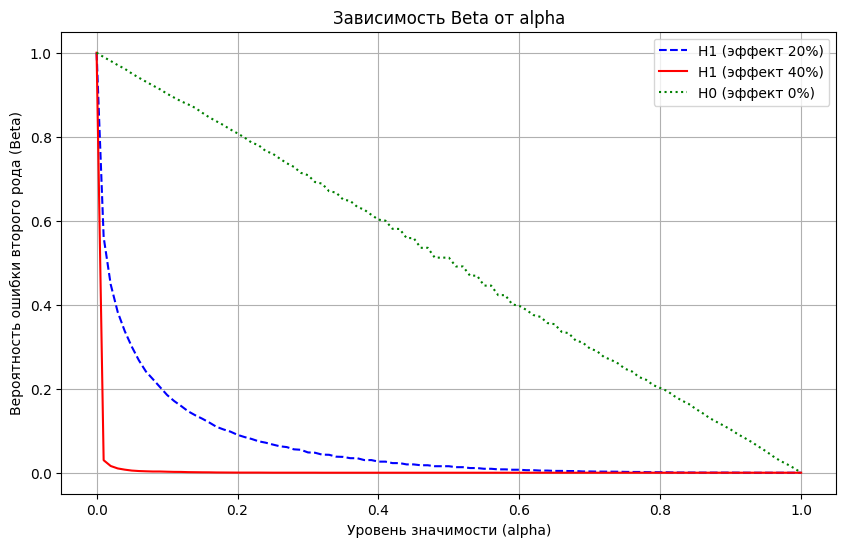

In [30]:
# Функция для вычисления beta 
def calculate_beta(p_values, alpha):
    return np.mean(np.array(p_values) >= alpha)

# alpha от 0 до 1
alphas = np.arange(0, 1.01, 0.01)

# Вычисляем beta для каждого alpha
beta_h1_20 = [calculate_beta(ps_h1_20, alpha) for alpha in alphas]
beta_h1_40 = [calculate_beta(ps_h1_40, alpha) for alpha in alphas]
beta_h0 = [calculate_beta(ps_h0, alpha) for alpha in alphas]  

# Построение графиков
plt.figure(figsize=(10, 6))

plt.plot(alphas, beta_h1_20, label='H1 (эффект 20%)', linestyle='--', color='blue')
plt.plot(alphas, beta_h1_40, label='H1 (эффект 40%)', linestyle='-', color='red')
plt.plot(alphas, beta_h0, label='H0 (эффект 0%)', linestyle=':', color='green')

plt.xlabel('Уровень значимости (alpha)')
plt.ylabel('Вероятность ошибки второго рода (Beta)')
plt.title('Зависимость Beta от alpha')
plt.legend()
plt.grid(True)
plt.show()

Вместо осей $(\alpha, \beta)$ обычно такой график рисуют в осях $(\alpha, 1 - \beta)$. Давайте построим его и проинтерпретируем.

In [31]:
def plot_pvalue_distribution(dict_pvalues):
    xseq = np.linspace(0, 1, 1000)

    for key, pvalues in dict_pvalues.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=key)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Распределение p-value/ROC-кривая', size=16)
    plt.xlabel('alpha', size=12)
    plt.ylabel('1 - beta', size=12)
    plt.legend(fontsize=12)
    plt.grid()

Заполните пропуски в коде ниже, чтобы для нашего АБ-теста отрисовались ROC-кривые.

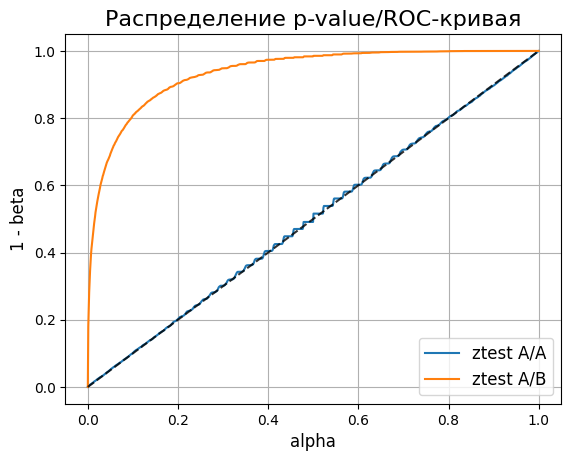

In [32]:
n_sim = 10**4
sample_size = 1000
p_control = 0.2

dict_pvalues = defaultdict(list)
for _ in range(n_sim):

    x_control, x_treatment = gen_sample(sample_size, effect=0.2, p_control=p_control)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment, alternative='larger')

    # сгенерируем ещё одну тестовую выборку, чтобы убедиться, что в случае когда выборки совпали,
    # наш тест работает корректно и не находит разницу

    x_control_again, _ = gen_sample(1000, 0, p_control)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again) # вообще я сейчас подумал разве тут не будет корректнее использовать lternative='two-sided'? (Изначальная версия программы была такая)

    dict_pvalues['ztest A/A'].append(pval_aa)
    dict_pvalues['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(dict_pvalues)

Получившийся график можно проинтерпретировать двумя способами. Мы много-много раз проводим АБ-тест. В начале теста мы зафиксировали какую-то $\alpha$ и дальше проверяем кучу гипотез.

1. Линия `ztest A/A` это функция распределения pvalue при верности нулевой гипотезы. Оно было равномерным, мы двигаем $\alpha$ по оси $OX$ и оцениваем $\mathbb{P}(\text{pvalue} \le \alpha) = F(\alpha)$.  

По аналогии, линия `ztest A/B` это функция распределения pvalue при верности альтернативной гипотезы.

2. Линию `ztest A/B` можно проинтерпретировать как ROC-кривую. Если вы уже знаете про задачу классификации из машинного обучения, то это ровно оно. Полнота это $1 - \beta$, то есть то, сколько верных альтернативных гипотез мы найдём, если будем использовать наш АБ-тест, FPR это $\alpha$, то есть то, сколько верных нулевых гипотез мы заберём с собой в альтернативные. Эту величину мы определяем до старта эксперимента.

> Важно: если вы не поняли интерпретацию из пункта 2, просто забейте. Заботаете МО, поймёте. Интерпретацию из пункта 1 должны понять все. Если вы её не поняли, время напрячься и подумать ещё разок.

__Что для нас важно:__

- Чем выпуклее график, тем лучше мы находим эффект и процедура проверки гипотезы работае корректно;
- Чем больше у нас наблюдений тем выпуклее график;
- Чем сильнее в тестовой выборке подскакивает $p_t$ при изменениях, тем легче нам найти эффект и тем выпуклее график;
- Если $p_t$ подскочило на очень маленькую величину, нам сложнее найти это изменение, и график будет менее выпуклым;
- Чем меньше в выборках дисперсия, тем выпуклее график.

__е) [2 балла]__ При верности альтернативной гипотезы, постройте ROC-кривые из пункта выше для разного числа наблюдений в выборке: 10, 100, 1000, 10000 при любом фиксированном эффекте.

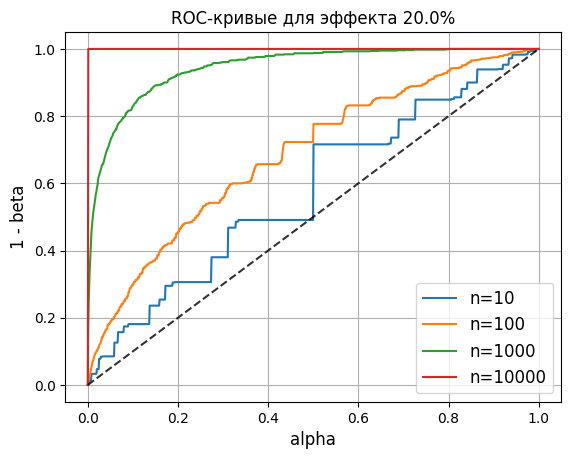

In [33]:
def simulate_pvalues(n_obs, effect, n_sim=1000):
    # генерируем p-value для заданного размера выборки и эффекта
    pvalues = []
    for _ in range(n_sim):
        x_c, x_t = gen_sample(n_obs, effect, p_control)
        _, p = asy_mean_test(x_c, x_t) 
        pvalues.append(p)
    return pvalues

# параметры симуляции
effect = 0.2  
sample_sizes = [10, 100, 1000, 10000]
dict_pvalues = defaultdict(list)

# Генерация данных для каждого размера выборки
for size in sample_sizes:
    dict_pvalues[f'n={size}'] = simulate_pvalues(size, effect)

# Построение ROC-кривых
plot_pvalue_distribution(dict_pvalues)
plt.title(f'ROC-кривые для эффекта {effect*100}%')
plt.show()

__ё) [1 балл]__ Количество наблюдений, ошибка 1 и 2 рода, размер эффекта, который мы ищем и дисперсия в выборках связаны между собой. Для некоторых критериев проверки гипотез можно вывести формулы, которые их связывают.

В данном случае, формула для расчета числа наблюдений _для одной группы_ выглядит вот так:

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

В приложении Яндекс.Такси в конце поездки вылезают рандомные опросники. В одном из опросников задаётся вопрос «А вы пристёгивались, когда ехали?»

В России, в день, в Такси происходит 1 миллион заказов. Вопрос про ремни задаётся рандомным 10% пользователей, закончивших поездку. Пользователь не игнорирует опросник и отвечает на него да или нет с вероятностью 5% (цифры взяты из головы и не отражают реальную статистику).

Менеджер Екатерина хочет сделать так, чтобы когда пассажир садится в машину, Алиса просила его пристегнуться. Хочется замерить, какой эффект это даст на пристёгивания. Станут ли люди чаще пристёгиваться. Замерять мы это будем опросником. Сейчас 10% пользователей говорят, что пристегнулись.

Екатерина пришла к вам и между вами состоялся следующий диалог:

- Хочу АБ-тест с разбивкой 50 на 50.
- Какие ошибки 1 и 2 рода хочешь?
- Нулевые.
- Нам надо бесконечно наблюдений, готова столько ждать?
- Нет.
- На сколько мы хотим, чтобы выросла доля ответов да?
- Если подрастёт хотябы на процент, будет круто.
- То есть если меньше процента, такой эффект считаем неудачей и отсутствием изменения?
- Да.
- Давай я нарисую тебе табличку с разными ошибками, а внутри на пересечении напишу сколько дней надо ждать, чтобы найти такой минимальный эффект.
- Давай, по ней и примем решение.

In [34]:
def calculate_required_days(alpha, beta, p_control=0.10, mde=0.01, daily_users=1e6):
    p_treatment = p_control + mde
    var_c = p_control * (1 - p_control)
    var_t = p_treatment * (1 - p_treatment)
    
    # Квантили нормального распределения 
    z_alpha = stats.norm.ppf(1 - alpha)
    z_beta = stats.norm.ppf(1 - beta)
    
    # Расчет необходимого размера выборки
    n_per_group = ((z_alpha + z_beta)**2 * (var_c + var_t)) / (mde**2)
    total_n = 2 * n_per_group
    
    # Ежедневный объем данных 
    daily_data = daily_users * 0.1 * 0.05 * 0.5  # 10% опросов, 5% ответов, 50/50 сплит
    days = np.ceil(total_n / daily_data)
    
    return int(days)

# Параметры для таблицы
alphas = [0.01, 0.05, 0.10]
betas = [0.10, 0.20, 0.30]

results = []
for alpha in alphas:
    row = []
    for beta in betas:
        days = calculate_required_days(alpha, beta)
        row.append(days)
    results.append(row)

df = pd.DataFrame(results,
                 index=[f'alpha={a}' for a in alphas],
                 columns=[f'beta={b}' for b in betas])

print("Таблица необходимого количества дней:")
df

Таблица необходимого количества дней:


,beta=0.1,beta=0.2,beta=0.3
alpha=0.01,20,16,13
alpha=0.05,13,10,8
alpha=0.1,10,7,5


__ж) [1 балл]__ Попробуем сломать наш АБ-тест. Когда мы используем z-тест, мы размышляем в терминах центральной предельной теоремы. Тест будет работать, если выполнены предпосылки ЦПТ:

- Наблюдения независимо одинаково распределены
- В данных нет выборосов, дисперсия конечная
- Данных много

Давайте сломаем одно из условий и попробуем собрать выборку из [распределения Парето](https://ru.wikipedia.org/wiki/Распределение_Парето).

In [35]:
def gen_sample(n_obs, effect, b=0.5):
    x_control = stats.pareto(b=b).rvs(n_obs)
    x_treatment = stats.pareto(b=b).rvs(n_obs)
    x_treatment = (1 + effect) * x_treatment
    return x_control, x_treatment

Отрисуйте ROC-кривые для $b=3$, $b=1$, $b=0.5$

Возьмите при каждом $b$ одну выборку, нарисуйте для неё гистограмму и посмотрите как обстоят дела с выбросами.

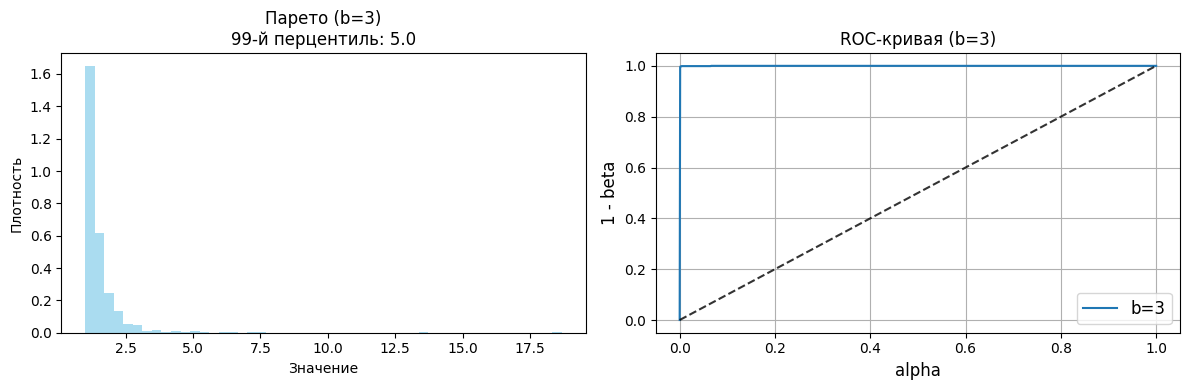

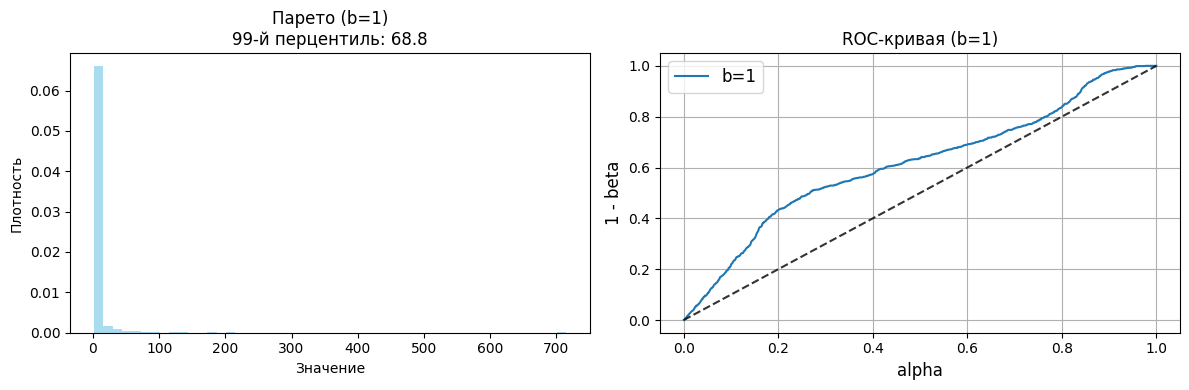

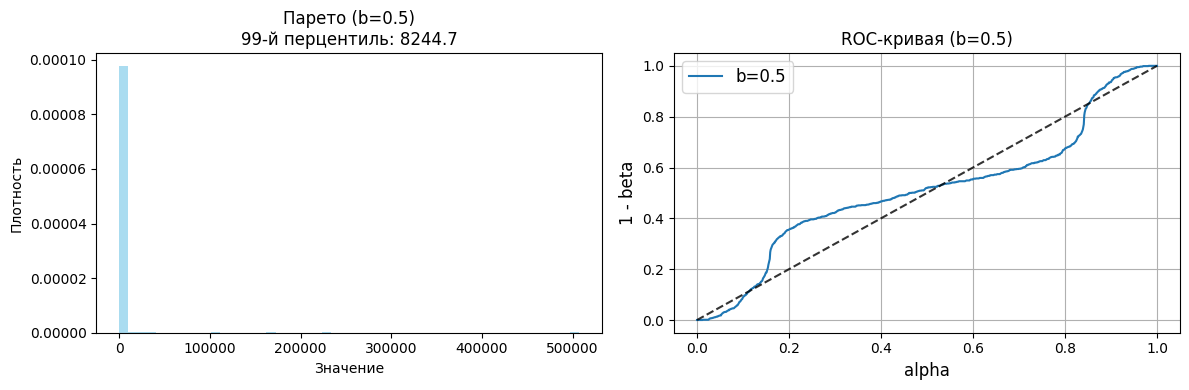

In [36]:
# анализ распределения Парето
def analyze_pareto_effect(b_values, effect=0.2, n_obs=1000):
    dict_pvalues = defaultdict(list)
    
    for b in b_values:
        # Гистограмма одной выборки 
        x_control, _ = gen_sample(n_obs, 0, b)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.hist(x_control, bins=50, density=True, color='skyblue', alpha=0.7)
        plt.title(f'Парето (b={b})\n99-й перцентиль: {np.percentile(x_control, 99):.1f}')
        plt.xlabel('Значение')
        plt.ylabel('Плотность')

        # Симуляция p-значений
        p_values = []
        for _ in range(1000):
            x_c, x_t = gen_sample(n_obs, effect, b)
            _, p = asy_mean_test(x_c, x_t, alternative='larger')
            p_values.append(p)
        dict_pvalues[f'b={b}'] = p_values

        # ROC-кривая
        plt.subplot(1, 2, 2)
        plot_pvalue_distribution({f'b={b}': p_values})
        plt.title(f'ROC-кривая (b={b})')
        plt.tight_layout()
        plt.show()

# Анализ для разных значений параметра b
analyze_pareto_effect(b_values=[3, 1, 0.5], effect=0.2)

1) **При b=3 (умеренные хвосты):**
   * дисперсия конечна
   * 99-й перцентиль выборки: **4.9**.
   * ROC‑кривая выпуклая, z-тест работает корректно.

2) **При b=1 (тяжёлые хвосты):**
   * 99-й перцентиль выборки: **83.0**.
   * ROC-кривая деградирует, мощность теста снижается. Тест частично теряет эффективность.

3) **При b=0.5 (экстремальные выбросы):**
   * 99-й перцентиль выборки достигает **8009.6**.
   * ROC-кривая совпадает с диагональю, тест полностью бесполезен. Z-статистика не работает.

### P.S Цифры в выводах могут отличаться, по-скольку я перезапускал код, в следующий раз зафиксирую seed программы

У распределения Парето не всегда существует дисперсия. Это ломает предпосылки ЦПТ и АБ-тест разваливается.

Возникает вполне резонный вопрос: а что делать в таких ситуациях? Есть несколько дорог.

- Во-первых, можно отвязаться от математического ожидания и поработать с медианой. Для неё тоже можно вывести асимптотическое распределение с помощью дельта-метода.
- Во-вторых, можно попробовать другие техники проверки гипотез. Например, бутстрап и непараметрические критерии.

Об этом мы и будем говорить на следующих парах.